In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

verbose_print = True

def log(*args, **kwargs):
    if verbose_print:
        print("LOG:", *args, **kwargs)

np.random.seed(42)

In [2]:
def load_csv(path):
    full = os.path.join('diabetes', path)
    return pd.read_csv(full)

original = load_csv('diabetic_data_balanced.csv')
df = original.copy()

pd.set_option('display.max_columns', None)

In [3]:
unknown_token = "bamboozled"

def get_unique_pairs(df):
    pairs = []
    
    for col in df.columns:
        pairs.append((col, df[col].unique().shape[0]))
    
    # Sort them by occurrence
    ret = np.array(pairs)
    sort_idx = np.argsort(ret[:, 1].astype(int))
    ret = ret[sort_idx]
    return ret

def get_singular_cols(df):
    singular_cols = []
    unq_pairs = get_unique_pairs(df)
    
    for col, unq in unq_pairs:
        if int(unq) == 1:
            singular_cols.append(col)
    
    log("Singular columns:", singular_cols)
    return singular_cols

def get_cat_cols(df):
    return df.select_dtypes(include='object').columns

In [4]:
def features_response(df):
    return df.drop('readmitted', axis=1), df['readmitted']

def drop_columns(df, columns):
    log("Dropping columns:", columns)
    return df.drop(columns, axis=1)

def fill_na_inplace(df, columns):
    log("Filling na in columns:", columns)
    df[columns] = df[columns].fillna(value=unknown_token)

def transf_age_inplace(df):
    num_ages = np.linspace(5, 95, 10)
    cat_ages = df['age'].unique()

    for cat, num in zip(cat_ages, num_ages):
        log("Replacing", cat, "with", num)
        df['age'].replace(to_replace=cat, value=num, inplace=True)
        
def bin_columns(df, cols):
    log("Binarizing columns", cols)
    return pd.get_dummies(df, columns=cols, drop_first=True)

In [5]:
def add_presence_cols(df, cols):
    log("Adding presence columns for", cols)
    for col in cols:
        df[col+'_present'] = (~df[col].isna()).astype(int)

In [6]:
def compress_feature_inplace(df, cols, keep_num, isfrac=False):
    if not isfrac:
        log("Keeping top", keep_num, "of columns", cols)
    else:
        log("Keeping top", keep_num, " fraction of columns", cols)
    
    compressed_token = unknown_token
    
    for col in cols:
        idx_sort = reversed(np.argsort(df[col].value_counts()))
        series = df[col].value_counts()[idx_sort]
        
        vals = series.values
        labels = series.index
        
        if isfrac:
            tarsum = np.sum(vals) * keep_num
            cursum = 0

            start_from = 0
            for val in vals:
                if cursum >= tarsum:
                    break
                cursum += val
                start_from += 1
        else:
            cursum = None
            start_from = keep_num
        
        log(f"Compressing values from {start_from} to {len(labels)} until the end (cumsum = {cursum})")
        
        for lbl in labels[start_from:]:
            df[col].replace(lbl, compressed_token, inplace=True)

In [7]:
def diag_type(seq):
    
    seq = str(seq)
    
    if seq[0] == 'E':
        return 'injury and poisoning'
    if seq[0] == 'V':
        return 'Supplementary Classification of Factors influencing Health Status and Contact with Health Services'
    if seq[0] == 'M':
        return 'Morphology of Neoplasms'
    
    num = float(seq)
    
    if math.isnan(num):
        return 'None'
    
    if num <= 139:
        return 'Infectious and Parasitic Diseases'
    elif num <= 239:
        return 'Neoplasms'
    elif num <= 279:
        return 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders'
    elif num <= 289:
        return 'Diseases of the Blood and Blood-forming Organs'
    elif num <= 319:
        return 'Mental Disorders'
    elif num <= 389:
        return 'Diseases of the Nervous System and Sense Organs'
    elif num <= 459:
        return 'Diseases of the Circulatory System'
    elif num <= 519:
        return 'Diseases of the Respiratory System'
    elif num <= 579:
        return 'Diseases of the Digestive System'
    elif num <= 629:
        return 'Diseases of the Genitourinary System'
    elif num <= 679:
        return 'Complications of Pregnancy, Childbirth, and the Puerperium'
    elif num <= 709:
        return 'Diseases of the Skin and Subcutaneous Tissue'
    elif num <= 739:
        return 'Diseases of the Musculoskeletal System and Connective Tissue'
    elif num <= 759:
        return 'Congenital Anomalies'
    elif num <= 779:
        return 'Certain Conditions originating in the Perinatal Period'
    elif num <= 799:
        return 'Symptoms, Signs and Ill-defined Conditions'
    elif num <= 999:
        return 'Injury and Poisoning'
    else:
        return 'DON\'T KNOW'

def clever_compress_diags_inplace(df):
    diags = ['diag_1', 'diag_2', 'diag_3']
    
    for diag in diags:
        df[diag] = np.vectorize(diag_type)(df[diag])

In [8]:
def drop_bad_values(df, df_labels, col, to_drop):
    log(f"In column {col}, dropping values {to_drop}")
    
    for hey in to_drop:
        idx = df[col] != hey
        df, df_labels = df[idx], df_labels[idx]
    return df, df_labels

In [9]:
all_meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'sitagliptin', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

def meds_drop_inplace(df):
    log(f"Dropping binary medicine features")
    cols = df.columns
    dropped = []
    
    for med in all_meds:
        if med in cols:
            dropped.append(med)
    
    df.drop(dropped, axis=1, inplace=True)
    log(f"Dropped medicines: {dropped}")

def compress_meds_inplace(df):
    log(f"Creating compressed count features for medicines...")
    
    cols = list(df.columns)
    
    ex_meds = []
    for med in all_meds:
        if med in cols:
            ex_meds.append(med)
    
    log(f"Existing medicines are {ex_meds}")
    pos_vals = ['No_cnt', 'Steady_cnt', 'Up_cnt', 'Down_cnt']
    for v in pos_vals:
        df[v] = 0
    
    for index, row in df.iterrows():
        for med in ex_meds:
            name = row[med] + "_cnt"
            
            df.at[index, name] += 1
    log(f"Successfully created columns {pos_vals}")

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

def process_df(df, labels):
    # Split into train and test
    
    X_all, y_all = df.values, labels.values
    feature_names = df.columns

    X_all = StandardScaler().fit_transform(X_all)

    sss = StratifiedShuffleSplit(n_splits=1, random_state=42)
    train_full_idx, test_idx = next(sss.split(X_all, y_all))

    X_train_full, y_train_full = X_all[train_full_idx], y_all[train_full_idx]
    X_test, y_test = X_all[test_idx], y_all[test_idx]

    # Further split train into train and validation
    sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)

    train_idx, dev_idx = next(sss.split(X_train_full, y_train_full))
    X_train, y_train = X_train_full[train_idx], y_train_full[train_idx]
    X_dev, y_dev = X_train_full[dev_idx], y_train_full[dev_idx]

    log(f"Shape of train: {X_train.shape}, {y_train.shape}")
    log(f"Shape of dev: {X_dev.shape}, {y_train.shape}")
    log(f"Shape of test: {X_test.shape}, {y_test.shape}")
    
    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def eval_model(model, X_train, y_train, X_test, y_test, feature_names, verbose=True, importances=True):
    full_X = np.concatenate((X_train, X_test))
    full_y = np.concatenate((y_train, y_test))
    
    log(f"Model {model}")
    print(f"Cross val score: {np.mean(cross_val_score(model, full_X, full_y, cv=10))}")
    
    log("---------------------------------------------------------------\n\n")

In [12]:
from sklearn.linear_model import LogisticRegression

def simple_eval_ds(df, labels, verbose=False):
    feature_names = np.array(df.columns)
    log("Evaluating dataset with", len(df.columns), " features")
    X_train, y_train, X_dev, y_dev, X_test, y_test = process_df(df, labels)
    
    model = RandomForestClassifier(n_estimators=20, n_jobs=3, random_state=42)
    model.fit(X_train, y_train)
    
    imp = model.feature_importances_
    
    pred_train = model.predict(X_train)
    pred = model.predict(X_test)
    
    print(f"Accuracy score: {accuracy_score(y_test, pred)}")
    
    if verbose:
        log(f"Accuracy score on train data: {accuracy_score(y_train, pred_train)}")
        log(f"Precision score: {precision_score(y_test, pred, average='weighted')}")
        log(f"Recall score: {recall_score(y_test, pred, average='weighted')}")
        log(f"F1 score: {f1_score(y_test, pred, average='weighted')}")

        labels_unq = ['<30', '>30', 'NO']
        conf_mx = confusion_matrix(y_test, pred, labels=labels_unq)
        log(f"Confusion matrix (labels = {labels_unq}:\n{conf_mx}")

        plt.imshow(conf_mx, cmap = "jet")
        plt.colorbar()
        plt.show()
    
    top_n = 15
    srt_idx = np.argsort(-imp)
    srt_idx = srt_idx[:top_n]
    
    plt.barh(feature_names[srt_idx], imp[srt_idx])
    plt.title(f"Top {top_n} feature importances")
    plt.show()
    
    eval_model(model, X_train, y_train, X_dev, y_dev, df.columns, verbose)
    
def logreg_eval_ds(df, labels, verbose=False):
    log("Evaluating dataset with", len(df.columns), " features using logistic regression")
    feature_names = np.array(df.columns)
    X_train, y_train, X_dev, y_dev, X_test, y_test = process_df(df, labels)
    
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    imp_all = model.coef_
    
    pred_train = model.predict(X_train)
    pred = model.predict(X_test)
    
    print(f"Accuracy score: {accuracy_score(y_test, pred)}")
    
    if verbose:
        log(f"Accuracy score on train data: {accuracy_score(y_train, pred_train)}")
        log(f"Precision score: {precision_score(y_test, pred, average='weighted')}")
        log(f"Recall score: {recall_score(y_test, pred, average='weighted')}")
        log(f"F1 score: {f1_score(y_test, pred, average='weighted')}")

        labels_unq = ['<30', '>30', 'NO']
        conf_mx = confusion_matrix(y_test, pred, labels=labels_unq)
        log(f"Confusion matrix (labels = {labels_unq}:\n{conf_mx}")

        plt.imshow(conf_mx, cmap = "jet")
        plt.colorbar()
        plt.show()
    
    for i in range(len(imp_all)):
        imp = imp_all[i]
        clas = model.classes_[i]
        
        top_n = 15
        srt_idx = np.argsort(imp**2)
        srt_idx = srt_idx[:top_n]
        
        plt.barh(feature_names[srt_idx], imp[srt_idx])
        plt.title(f"Top {top_n} feature importances for class {clas}")
        plt.show()
    
    eval_model(model, X_train, y_train, X_dev, y_dev, df.columns, verbose)
    

LOG: Dropping columns: ['weight', 'payer_code', 'encounter_id', 'patient_nbr']
LOG: Filling na in columns: ['race']
LOG: Replacing [0-10) with 5.0
LOG: Replacing [10-20) with 15.0
LOG: Replacing [20-30) with 25.0
LOG: Replacing [30-40) with 35.0
LOG: Replacing [40-50) with 45.0
LOG: Replacing [50-60) with 55.0
LOG: Replacing [60-70) with 65.0
LOG: Replacing [70-80) with 75.0
LOG: Replacing [80-90) with 85.0
LOG: Replacing [90-100) with 95.0
LOG: Singular columns: ['metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'citoglipton', 'examide', 'acetohexamide']
LOG: Dropping columns: ['metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'citoglipton', 'examide', 'acetohexamide']
LOG: Binarizing columns ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
LOG: Binarizing columns Index(['race', 'gender', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
       'max_glu_

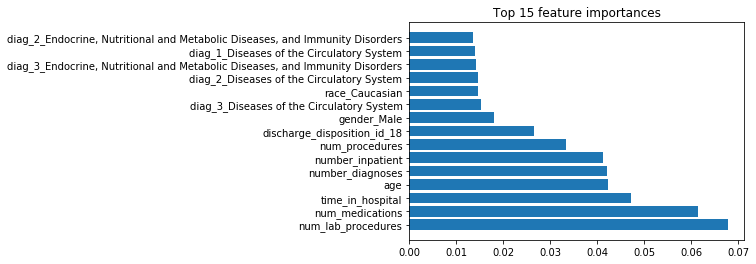

LOG: Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=3,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Cross val score: 0.49938808552712893
LOG: ---------------------------------------------------------------


LOG: Evaluating dataset with 190  features using logistic regression
LOG: Shape of train: (7199, 190), (7199,)
LOG: Shape of dev: (1800, 190), (7199,)
LOG: Shape of test: (1000, 190), (1000,)


/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/simeon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


KeyboardInterrupt: 

In [13]:
# Baseline mades
my_a1, my_a1_y = features_response(df)
my_a1 = drop_columns(my_a1, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])

clever_compress_diags_inplace(my_a1)
fill_na_inplace(my_a1, ['race'])

transf_age_inplace(my_a1)

my_a1 = drop_columns(my_a1, get_singular_cols(my_a1))
my_a1 = bin_columns(my_a1, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my_a1 = bin_columns(my_a1, get_cat_cols(my_a1))
simple_eval_ds(my_a1, my_a1_y)
logreg_eval_ds(my_a1, my_a1_y)

In [ ]:
# Drop meds
my_a1, my_a1_y = features_response(df)
my_a1 = drop_columns(my_a1, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])

clever_compress_diags_inplace(my_a1)
fill_na_inplace(my_a1, ['race'])

meds_drop_inplace(my_a1)

transf_age_inplace(my_a1)

my_a1 = drop_columns(my_a1, get_singular_cols(my_a1))
my_a1 = bin_columns(my_a1, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my_a1 = bin_columns(my_a1, get_cat_cols(my_a1))
simple_eval_ds(my_a1, my_a1_y)
logreg_eval_ds(my_a1, my_a1_y)

In [ ]:
# Compress meds & drop old
my_a2, my_a2_y = features_response(df)
my_a2 = drop_columns(my_a2, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])

compress_meds_inplace(my_a2)
meds_drop_inplace(my_a2)

clever_compress_diags_inplace(my_a2)
fill_na_inplace(my_a2, ['race'])

transf_age_inplace(my_a2)

my_a2 = drop_columns(my_a2, get_singular_cols(my_a2))
my_a2 = bin_columns(my_a2, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my_a2 = bin_columns(my_a2, get_cat_cols(my_a2))
simple_eval_ds(my_a2, my_a2_y)
logreg_eval_ds(my_a2, my_a2_y)

In [ ]:
# Compress meds & KEEP old
my_a3, my_a3_y = features_response(df)
my_a3 = drop_columns(my_a3, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])

compress_meds_inplace(my_a3)

clever_compress_diags_inplace(my_a3)
fill_na_inplace(my_a3, ['race'])

transf_age_inplace(my_a3)

my_a3 = drop_columns(my_a3, get_singular_cols(my_a3))
my_a3 = bin_columns(my_a3, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my_a3 = bin_columns(my_a3, get_cat_cols(my_a3))
simple_eval_ds(my_a3, my_a3_y)
logreg_eval_ds(my_a3, my_a3_y)

In [ ]:
# Drop diags
diags_drop, diags_drop_y = features_response(df)
diags_drop = drop_columns(diags_drop, ['weight', 'payer_code', 'encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3'])

fill_na_inplace(diags_drop, ['race'])

diags_drop = drop_columns(diags_drop, get_singular_cols(diags_drop))

transf_age_inplace(diags_drop)
diags_drop = bin_columns(diags_drop, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
diags_drop = bin_columns(diags_drop, get_cat_cols(diags_drop))
simple_eval_ds(diags_drop, diags_drop_y)

In [ ]:
# Keep 95% of diags
diags_95, diags_95_y = features_response(df)
diags_95 = drop_columns(diags_95, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])

fill_na_inplace(diags_95, ['race', 'diag_1', 'diag_2', 'diag_3'])

compress_feature_inplace(diags_95, ['diag_1', 'diag_2', 'diag_3'], 0.95, True)
diags_95 = drop_columns(diags_95, get_singular_cols(diags_95))

transf_age_inplace(diags_95)
diags_95 = bin_columns(diags_95, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
diags_95 = bin_columns(diags_95, get_cat_cols(diags_95))
simple_eval_ds(diags_95, diags_95_y)

In [ ]:
# Keep all diags
diags_full, diags_full_y = features_response(df)
diags_full = drop_columns(diags_full, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])

fill_na_inplace(diags_full, ['race', 'diag_1', 'diag_2', 'diag_3'])

diags_full = drop_columns(diags_full, get_singular_cols(diags_full))

transf_age_inplace(diags_full)
diags_full = bin_columns(diags_full, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
diags_full = bin_columns(diags_full, get_cat_cols(diags_full))
simple_eval_ds(diags_full, diags_full_y)

In [ ]:
# Diags
diags_clev, diags_clev_y = features_response(df)
diags_clev = drop_columns(diags_clev, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])
clever_compress_diags_inplace(diags_clev)

print(diags_clev['diag_1'].value_counts())
print(len(diags_clev['diag_1'].value_counts()))

fill_na_inplace(diags_clev, ['race'])

diags_clev = drop_columns(diags_clev, get_singular_cols(diags_clev))

transf_age_inplace(diags_clev)
diags_clev = bin_columns(diags_clev, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
diags_clev = bin_columns(diags_clev, get_cat_cols(diags_clev))
simple_eval_ds(diags_clev, diags_clev_y)

In [ ]:
#Being as stupid as possible
my0, my0_y = features_response(df)
my0 = drop_columns(my0, ['weight', 'payer_code', 'diag_1', 'diag_2', 'diag_3', 'encounter_id', 'patient_nbr', 'medical_specialty', 'race'])
# my0 = drop_columns(my0, get_singular_cols(my0))
# transf_age_inplace(my0)
# my0 = bin_columns(my0, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my0 = bin_columns(my0, get_cat_cols(my0))
simple_eval_ds(my0, my0_y)

In [ ]:
# Common sense configuration
my1, my1_y = features_response(df)
my1 = drop_columns(my1, ['weight', 'payer_code', 'encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3'])
fill_na_inplace(my1, ['race'])
my1 = drop_columns(my1, get_singular_cols(my1))
transf_age_inplace(my1)
my1 = bin_columns(my1, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my1 = bin_columns(my1, get_cat_cols(my1))
simple_eval_ds(my1, my1_y)

In [ ]:
# This is dropping medical_specialty
my2, my2_y = features_response(df)
my2 = drop_columns(my2, ['medical_specialty', 'weight', 'payer_code', 
                         'diag_1', 'diag_2', 'diag_3', 'encounter_id', 'patient_nbr'])
fill_na_inplace(my2, ['race'])
my2 = drop_columns(my2, get_singular_cols(my2))
transf_age_inplace(my2)
my2 = bin_columns(my2, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my2 = bin_columns(my2, get_cat_cols(my2))
simple_eval_ds(my2, my2_y)

In [ ]:
# This is compressing medical_specialty to first 80% (keeping 8)
my25, my25_y = features_response(df)
my25 = drop_columns(my25, ['weight', 'payer_code', 
                         'diag_1', 'diag_2', 'diag_3', 'encounter_id', 'patient_nbr'])
fill_na_inplace(my25, ['race'])
my25 = drop_columns(my25, get_singular_cols(my25))
compress_feature_inplace(my25, ['medical_specialty'], 0.8, True)
transf_age_inplace(my25)
my25 = bin_columns(my25, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my25 = bin_columns(my25, get_cat_cols(my25))
simple_eval_ds(my25, my25_y)

In [ ]:
# This is compressing medical_specialty to first 95% (keeping 18)
my27, my27_y = features_response(df)
my27 = drop_columns(my27, ['weight', 'payer_code', 
                         'diag_1', 'diag_2', 'diag_3', 'encounter_id', 'patient_nbr'])
fill_na_inplace(my27, ['race'])
my27 = drop_columns(my27, get_singular_cols(my27))
compress_feature_inplace(my27, ['medical_specialty'], 0.95, True)
transf_age_inplace(my27)
my27 = bin_columns(my27, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my27 = bin_columns(my27, get_cat_cols(my27))
simple_eval_ds(my27, my27_y)

In [ ]:
# This is compressing medical_specialty to first 99% (keeping 29)
my28, my28_y = features_response(df)
my28 = drop_columns(my28, ['weight', 'payer_code', 
                         'diag_1', 'diag_2', 'diag_3', 'encounter_id', 'patient_nbr'])
fill_na_inplace(my28, ['race'])
my28 = drop_columns(my28, get_singular_cols(my28))
compress_feature_inplace(my28, ['medical_specialty'], 0.99, True)
transf_age_inplace(my28)
my28 = bin_columns(my28, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my28 = bin_columns(my28, get_cat_cols(my28))
simple_eval_ds(my28, my28_y)

In [ ]:
# Not dropping diagnoses
my3, my3_y = features_response(df)
my3 = drop_columns(my3, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])
fill_na_inplace(my3, ['medical_specialty', 'race', 'diag_1', 'diag_2', 'diag_3'])
my3 = drop_columns(my3, get_singular_cols(my3))
transf_age_inplace(my3)
my3 = bin_columns(my3, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my3 = bin_columns(my3, get_cat_cols(my3))
simple_eval_ds(my3, my3_y)

In [ ]:
# Not dropping diagnoses, keeping 50 % cumsum (about mean 15)
my4, my4_y = features_response(df)
my4 = drop_columns(my4, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])
fill_na_inplace(my4, ['medical_specialty', 'race', 'diag_1', 'diag_2', 'diag_3'])
compress_feature_inplace(my4, ['diag_1', 'diag_2', 'diag_3'], 0.5, True)
my4 = drop_columns(my4, get_singular_cols(my4))
transf_age_inplace(my4)
my4 = bin_columns(my4, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my4 = bin_columns(my4, get_cat_cols(my4))
simple_eval_ds(my4, my4_y)

In [ ]:
# Not dropping diagnoses, keeping top 0.7 of them (about 40)
my5, my5_y = features_response(df)
my5 = drop_columns(my5, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])
fill_na_inplace(my5, ['medical_specialty', 'race', 'diag_1', 'diag_2', 'diag_3'])
compress_feature_inplace(my5, ['diag_1', 'diag_2', 'diag_3'], 0.7, True)
my5 = drop_columns(my5, get_singular_cols(my5))
transf_age_inplace(my5)
my5 = bin_columns(my5, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my5 = bin_columns(my5, get_cat_cols(my5))
simple_eval_ds(my5, my5_y)

In [ ]:
# Not dropping diagnoses, keeping top 90% of them (about 125)
my6, my6_y = features_response(df)
my6 = drop_columns(my6, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])
fill_na_inplace(my6, ['medical_specialty', 'race', 'diag_1', 'diag_2', 'diag_3'])
compress_feature_inplace(my6, ['diag_1', 'diag_2', 'diag_3'], 0.9, True)
my6 = drop_columns(my6, get_singular_cols(my6))
transf_age_inplace(my6)
my6 = bin_columns(my6, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my6 = bin_columns(my6, get_cat_cols(my6))
simple_eval_ds(my6, my6_y)

In [ ]:
# Not dropping diagnoses, keeping top 95% of them (about 190 each)
my7, my7_y = features_response(df)
my7 = drop_columns(my7, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])
fill_na_inplace(my7, ['medical_specialty', 'race', 'diag_1', 'diag_2', 'diag_3'])
compress_feature_inplace(my7, ['diag_1', 'diag_2', 'diag_3'], 0.95, True)
my7 = drop_columns(my7, get_singular_cols(my7))
transf_age_inplace(my7)
my7 = bin_columns(my7, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my7 = bin_columns(my7, get_cat_cols(my7))
simple_eval_ds(my7, my7_y)

In [ ]:
# Not dropping diagnoses, keeping top 99% of them (about 340 each)
my8, my8_y = features_response(df)
my8 = drop_columns(my8, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])
fill_na_inplace(my8, ['medical_specialty', 'race', 'diag_1', 'diag_2', 'diag_3'])
compress_feature_inplace(my8, ['diag_1', 'diag_2', 'diag_3'], 0.99, True)
my8 = drop_columns(my8, get_singular_cols(my8))
transf_age_inplace(my8)
my8 = bin_columns(my8, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my8 = bin_columns(my8, get_cat_cols(my8))
simple_eval_ds(my8, my8_y)

In [ ]:
# Dropping secondary and tretriary diagnosis
my9, my9_y = features_response(df)
my9 = drop_columns(my9, ['weight', 'payer_code', 'encounter_id', 'patient_nbr', 'diag_2', 'diag_3'])
fill_na_inplace(my9, ['medical_specialty', 'race', 'diag_1'])
my9 = drop_columns(my9, get_singular_cols(my9))
transf_age_inplace(my9)
my9 = bin_columns(my9, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my9 = bin_columns(my9, get_cat_cols(my9))
simple_eval_ds(my9, my9_y)

In [ ]:
# Dropping tretriary diagnosis
my9, my9_y = features_response(df)
my9 = drop_columns(my9, ['weight', 'payer_code', 'encounter_id', 'patient_nbr', 'diag_3'])
fill_na_inplace(my9, ['medical_specialty', 'race', 'diag_1', 'diag_2'])
my9 = drop_columns(my9, get_singular_cols(my9))
transf_age_inplace(my9)
my9 = bin_columns(my9, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my9 = bin_columns(my9, get_cat_cols(my9))

simple_eval_ds(my9, my9_y)

In [ ]:
# Dropping tretriary diagnosis
my10, my10_y = features_response(df)
my10 = drop_columns(my10, ['weight', 'payer_code', 'encounter_id', 'patient_nbr', 'diag_3'])
fill_na_inplace(my10, ['medical_specialty', 'race', 'diag_1', 'diag_2'])
my10 = drop_columns(my10, get_singular_cols(my10))
transf_age_inplace(my10)
my10 = bin_columns(my10, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
my10 = bin_columns(my10, get_cat_cols(my10))

my10['noise'] = np.random.random(len(df))
simple_eval_ds(my10, my10_y)

In [ ]:
play = original.copy()
print("Unique values count: ", len(play['patient_nbr'].value_counts()))
play.groupby('patient_nbr', as_index=False).first()

In [ ]:
def first_unq_value(df, col):
    return df.groupby(col, as_index=False).first().reset_index(drop=True)

In [ ]:
# Keep just the first unique value
temp = original.copy()
temp = first_unq_value(temp, 'patient_nbr')

# Split into features and responses
fav, fav_y = features_response(temp)

# Drop columns with only 1 unique value
fav = drop_columns(fav, get_singular_cols(fav))

# Add a has_weight value
add_presence_cols(fav, ['weight'])

# Drop weight & payer_code (too few values), and encounter_id & patient_nbr (as they carry no info)
fav = drop_columns(fav, ['weight', 'payer_code', 'encounter_id', 'patient_nbr'])

# Drop meaningless discharge_disposition_ids
fav, fav_y = drop_bad_values(fav, fav_y, 'discharge_disposition_id', [11, 13, 14, 19, 20, 21])

# Fill na values creating an 'other' group
fill_na_inplace(fav, ['race'])

# Categorize diagnoses into more general groups
clever_compress_diags_inplace(fav)

# Keep only the first 99% of medical_specialty (in terms of the cumulative sum)
compress_feature_inplace(fav, ['medical_specialty'], 0.99, True)

# Turn age into a numerical value
transf_age_inplace(fav)

# Binarize categorical columns (and those that should be)
fav = bin_columns(fav, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
fav = bin_columns(fav, get_cat_cols(fav))

# Evaluate
simple_eval_ds(fav, fav_y)
# logreg_eval_ds(fav, fav_y)

In [ ]:
logreg_eval_ds(fav, fav_y)

In [ ]:
to_write = fav.copy()
to_write['readmitted'] = fav_y.copy()

to_write.to_csv('fav_ds.csv', index=False)

In [ ]:
fav.info()